In [ ]:
# %%capture --no-stderr
# %pip install -U tavily-python langchain_community


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# import os

# TAVILY_API_KEY = "<TAVILY_API_KEY>"

# os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

# import getpass
# import os

# if not os.environ.get("TAVILY_API_KEY"):
#     os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

In [ ]:
# %pip install -U langchain langchain-openai

# LANGSMITH_TRACING=true
# LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
# LANGSMITH_API_KEY="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"
# LANGSMITH_PROJECT="pr-shadowy-clay-24"
# OPENAI_API_KEY="<your-openai-api-key>"

# os.environ["LANGSMITH_TRACING"] = "true"
# os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

   ---------------------------------------- 0.0/567.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/567.4 kB ? eta -:--:--
   ------------------ --------------------- 262.1/567.4 kB ? eta -:--:--
   ---------------------------------------- 567.4/567.4 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from langchain_community.tools.tavily_search import  TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

tool.invoke("What's a node in LangChain?")

[{'title': 'Node — LangChain documentation',
  'url': 'https://python.langchain.com/v0.2/api_reference/core/graph_vectorstores/langchain_core.graph_vectorstores.base.Node.html',
  'content': 'Node — 🦜🔗 LangChain documentation Reference Reference beta chat_loaders chat_sessions document_loaders Node Link nodes_to_documents add_links copy_with_links get_links output_parsers outputs prompt_values prompts AI21 Google Community Nvidia Ai Endpoints LangChain Python API Reference Node Node# class langchain_core.graph_vectorstores.base.Node[source]# Beta This feature is in beta. Node in the GraphVectorStore. Edges exist from nodes with an outgoing link to nodes with a matching incoming link. For instance two nodes a and b connected over a hyperlink https://some-url would look like: Node( links\\= [ Link(kind\\="hyperlink", tag\\="https://some-url", direction\\="incoming") Node( links\\= [ Link(kind\\="hyperlink", tag\\="https://some-url", direction\\="outgoing") Unique ID for the node. param l

In [5]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state):
    return { "messages": [llm_with_tools.invoke(state["messages"])]}

CHATBOT = "chatbot"

graph_builder.add_node(CHATBOT, chatbot)

In [6]:
from langchain_core.messages import ToolMessage
import json

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools):
        self.tools_by_name = { tool.name: tool for tool in tools }
    
    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No messages in input")
        
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    toll_call_id=tool_call["id"]
                )
            )
        return {"messages": outputs}

tool_node = BasicToolNode(tools=[tool])
TOOLS = "tools"
graph_builder.add_node(TOOLS, tool_node)

In [7]:
def route_tools(state):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and ai_message.tool_calls:
        return TOOLS
    return END

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    CHATBOT,
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    { TOOLS: TOOLS, END: END }
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge(TOOLS, CHATBOT)
graph_builder.set_entry_point(CHATBOT)

graph = graph_builder.compile()


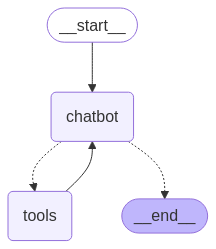

In [8]:
from IPython.display import display, Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
import os

ANTHROPIC_API_KEY = "ANTHROPIC_API_KEY"

os.environ["ANTHROPIC_API_KEY"] = ANTHROPIC_API_KEY

TAVILY_API_KEY = "TAVILY_API_KEY"

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [14]:
# Add the agent loop

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["q", "quit", "exist", "e"]:
            print("Bye, bye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback
        user_input = "What do you know about LangChain?"
        print("User: " + user_input)

        stream_graph_updates(user_input)
        break

User: What do you know about LangChain?


TypeError: "Could not resolve authentication method. Expected either api_key or auth_token to be set. Or for one of the `X-Api-Key` or `Authorization` headers to be explicitly omitted"